# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.regressor import StackingCVRegressor
import pandas_profiling
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
pandas_profiling.ProfileReport(df)

Удалим столбцы, в которых пропущены значения или значение ноль в более, чем 50% данных

In [6]:
data = df.drop(['2ndFlrSF', '3SsnPorch', 'Alley', 'BsmtFinSF2', 'EnclosedPorch', 'Fence', 'LowQualFinSF', 'MasVnrArea',
                  'MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC', 'ScreenPorch', 'WoodDeckSF', 'MasVnrType', 'Id'], axis=1)

Категориальные признаки и числовые:

In [7]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

В категориальных признаках пропущенным значениям присвоим None, а числовым - 0

In [8]:
for i in categorical_columns:
    data[i].fillna('None')
    
for j in numerical_columns:
    data[j].fillna(0)

Категориальные признаки приведем к числовым категориям

In [9]:
for i in categorical_columns:
    try:
        le = LabelEncoder()
        data[i] = le.fit_transform(data[i])
    except:
        continue

In [10]:
categorical_last = [c for c in data.columns if data[c].dtype.name == 'object']

In [11]:
data = data.drop(categorical_last, axis=1)

In [12]:
data = data.fillna(0)

Разделим данные на выборки для обучения и для предсказания

In [13]:
X = data.drop(['SalePrice'], axis=1)
y = data.SalePrice

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Модель случайный лес:

In [15]:
clf = RandomForestRegressor(n_estimators=10)
clf = clf.fit(X_train, y_train)

Оценим качество модели:

In [16]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(f'Оценка качества модели: {scores.mean():.2f}')

Оценка качества модели: 0.79


In [17]:
y_pred = clf.predict(X_test)
from sklearn.metrics import r2_score
print(f'R2 score: {r2_score(y_test, y_pred):.2f}')

R2 score: 0.88


Важность параметров в модели:

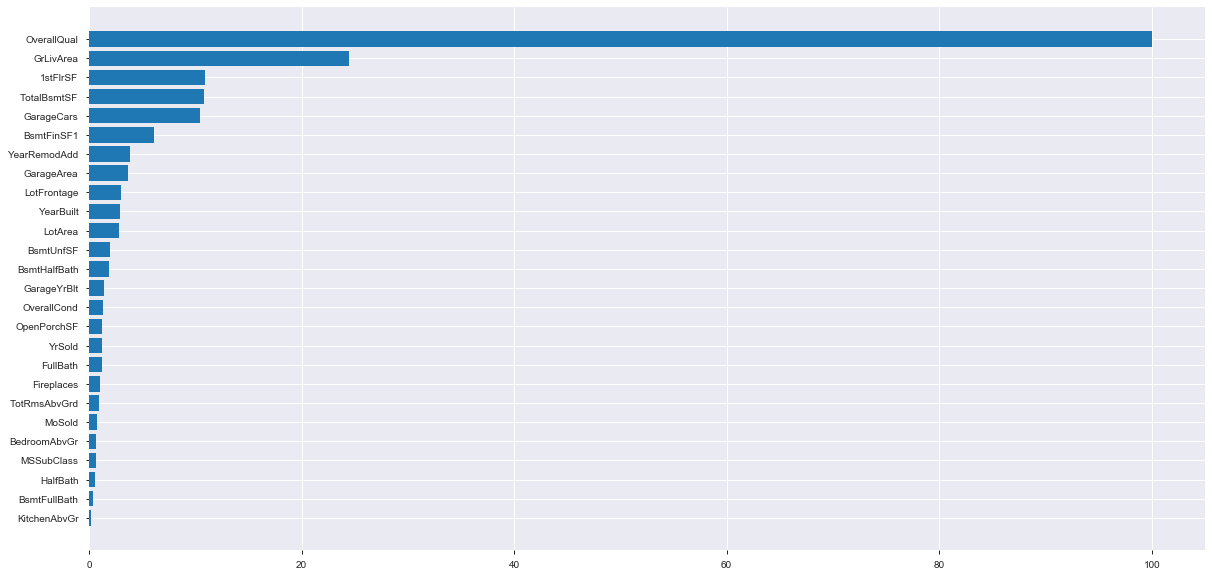

In [18]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data.columns[sorted_idx])
plt.show()

Модели для ансамбля:

In [21]:
estimators = [('linear', LinearRegression()), 
              ('svr', SVR()),
              ('tree', DecisionTreeRegressor())]

In [24]:
main = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))

Обучение модели:

In [25]:
main.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('linear',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('svr',
                               SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False)),
                              ('tree',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_fe...
                  final_estimator=RandomForestRegressor(bootstrap=True,
                                                        ccp_alpha=0.0

In [26]:
y_pred_main = main.predict(X_test)
from sklearn.metrics import r2_score
print(f'R2 score: {r2_score(y_test, y_pred_main):.2f}')

R2 score: 0.88


In [27]:
scores = cross_val_score(main, X_train, y_train, cv=10)
print(f'Оценка качества ансамбля: {scores.mean():.2f}')

Оценка качества ансамбля: 0.78
